Cohen, M. R., & Kohn, A. (2011). Measuring and interpreting neuronal correlations. Nature neuroscience, 14(7), 811-819.

In [9]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from scipy import stats
import seaborn as sns
import warnings
seed=2024

### Def functions

In [7]:
def align_all_trials_all_epochs(sp_sample_on,mask,neu_data,code_samples,time_before):
    alig = np.full((sp_sample_on.shape[0],sp_sample_on.shape[1]+1000),np.nan)
    t_s_off = ((code_samples[:,5] - code_samples[:,4] )+time_before).astype(int).tolist()
    t_d_off = ((code_samples[:,6] - code_samples[:,4] )+time_before).astype(int).tolist()
    max_dur_s = np.max(t_s_off)
    max_dur_d = np.max(t_d_off)
    for i in range(len(t_s_off)):
        # sample
        alig[i,:t_s_off[i]] = sp_sample_on[i,:t_s_off[i]]
        # delay
        alig[i,max_dur_s:max_dur_s+(t_d_off[i]-t_s_off[i])] = sp_sample_on[i,t_s_off[i]:t_d_off[i]]
        # test
        alig[i,max_dur_d:max_dur_d+(sp_sample_on.shape[1]-t_d_off[i])] = sp_sample_on[i,t_d_off[i]:]

    x = firing_rate.convolve_signal(arr=alig,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)

    s11_mask = neu_data.sample_id[mask] == 11
    s51_mask = neu_data.sample_id[mask] == 51
    s55_mask = neu_data.sample_id[mask] == 55
    s15_mask = neu_data.sample_id[mask] == 15
    s0_mask  = neu_data.sample_id[mask] == 0

    s11_mean = np.nanmean(x[s11_mask],axis=0)
    s51_mean = np.nanmean(x[s51_mask],axis=0)
    s55_mean = np.nanmean(x[s55_mask],axis=0)
    s15_mean = np.nanmean(x[s15_mask],axis=0)
    s0_mean  = np.nanmean(x[s0_mask ],axis=0)

    x_mean_sub = x.copy()
    x_mean_sub[s11_mask] = x_mean_sub[s11_mask]-s11_mean
    x_mean_sub[s51_mask] = x_mean_sub[s51_mask]-s51_mean
    x_mean_sub[s55_mask] = x_mean_sub[s55_mask]-s55_mean
    x_mean_sub[s15_mask] = x_mean_sub[s15_mask]-s15_mean
    x_mean_sub[s0_mask] = x_mean_sub[s0_mask]-s0_mean 

    x_no_nan = np.full(x_mean_sub.shape,np.nan)
    for i in range(x_mean_sub.shape[0]):
        no_nan = x_mean_sub[i,~np.isnan(x_mean_sub[i])]
        x_no_nan[i,:no_nan.shape[0]] = no_nan

### Analysis

In [8]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'D:/data/'#'C:/Users/camil/Documents/int/'

In [9]:
# Load data
n_test=1
min_trials=10
nonmatch=False
time_before_sample=500
time_before_test = 500
start=-200
start_test=-400
end_test = n_test*450
end_sample=450+400

idx_start_sample = time_before_sample + start 
idx_start_test = time_before_test + start_test 
idx_end_sample = time_before_sample+end_sample
idx_end_test = time_before_test+end_test
trial_dur = end_sample-start+end_test-start_test

In [10]:
area1='lip'
area2='v4'
subject='Riesling'

neu_path1 = basepath+'/session_struct/'+area1+'/neurons/*neu.h5'
all_path_list1 = glob.glob(neu_path1)
all_sessions = []
for ipath in all_path_list1:
    all_sessions.append(ipath.replace("\\", "/").split("/")[-1][:19])
all_sessions = np.unique(all_sessions)

neu_path2 = basepath+'/session_struct/'+area2+'/neurons/*neu.h5'
all_path_list2 = glob.glob(neu_path2)
all_path_list1 = glob.glob(neu_path1)

session = str(all_sessions[6])
session

'2022-12-14_10-50-49'

In [11]:
mask1,mask2 = [],[]
for path in all_path_list1:
    mask1.append(
        session == path.replace("\\", "/").rsplit("/")[-1].rsplit("_" + subject)[0]
    )
for path in all_path_list2:
    mask2.append(
        session == path.replace("\\", "/").rsplit("/")[-1].rsplit("_" + subject)[0]
    )
path_list1 = np.array(all_path_list1)[np.array(mask1)]
path_list2 = np.array(all_path_list2)[np.array(mask2)]

In [12]:
neurons1={}
neurons2={}
for iarea,path_list in zip([area1,area2],[path_list1,path_list2]):
    for i,path in enumerate(path_list):
        neu_data = NeuronData.from_python_hdf5(path)
        select_block=1
        code=1
        # Select trials aligned to sample onset
        sp_sample_on,mask = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="sample_on",
            time_before = time_before_sample,
            error_type= 0,
        )
        # Select trials aligned to sample onset
        sp_test_on,tmask = align_trials.align_on(
            sp_samples=neu_data.sp_samples,
            code_samples=neu_data.code_samples,
            code_numbers=neu_data.code_numbers,
            trial_error=neu_data.trial_error,
            block=neu_data.block,
            pos_code=neu_data.pos_code,
            select_block= select_block,
            select_pos= code,
            event ="test_on_1",
            time_before = time_before_test,
            error_type= 0,
        )

        if np.logical_or(np.mean(sp_sample_on[:,idx_start_sample:idx_end_sample])>5/1000,np.mean(sp_test_on[:,idx_start_test:idx_end_test])>5/1000):
            #sp_conv = firing_rate.convolve_signal(arr=sp_sample_on,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)
            sp_conv_sample = firing_rate.moving_average(sp_sample_on,win=100,step=1)[:,idx_start_sample:idx_end_sample]
            sp_conv_test = firing_rate.moving_average(sp_test_on,win=100,step=1)[:,idx_start_test:idx_end_test]
            sp_conv=np.concatenate((sp_conv_sample,sp_conv_test),axis=1)
            narea= neu_data.area
            cnumber=str(neu_data.cluster_number)
            cgroup=neu_data.cluster_group
            if iarea==area1:
                neurons1[narea + '_' +cgroup+cnumber] = {'fr':sp_sample_on,'conv':sp_conv,'path':path,'neu_data':neu_data,'mask':mask}
            if iarea==area2:
                neurons2[narea + '_' +cgroup+cnumber] = {'fr':sp_sample_on,'conv':sp_conv,'path':path,'neu_data':neu_data,'mask':mask}

c:\users\camil\documents\int\code\ephysvibe\ephysvibe\trials\spikes\firing_rate.py:47: RuntimeWarning: Mean of empty slice
  d_avg[:, count] = np.nanmean(data[:, st_win : i_step + win], axis=1)


In [13]:
neu_data = neurons1[list(neurons1.keys())[0]]['neu_data']
mask = neurons1[list(neurons1.keys())[0]]['mask']
code_samples=neu_data.code_samples[mask]
code_numbers=neu_data.code_numbers[mask]
s11_mask = neu_data.sample_id[mask] == 11
s51_mask = neu_data.sample_id[mask] == 51
s55_mask = neu_data.sample_id[mask] == 55
s15_mask = neu_data.sample_id[mask] == 15
s0_mask  = neu_data.sample_id[mask] == 0

In [14]:
corr_matrix={}
p_matrix={}
n1 = len(neurons1.keys())
n2 = len(neurons2.keys())
for isamp,imask in zip([0,11],[s0_mask,s11_mask]):#zip([0,11,15,51,55],[s0_mask,s11_mask,s15_mask,s51_mask,s55_mask]):#
    corr_m=np.full((n1,n2,trial_dur,trial_dur),np.nan)
    corr_p=np.full((n1,n2,trial_dur,trial_dur),np.nan)
    for i1,ineu1 in enumerate(neurons1.keys()):
        for i2,ineu2 in enumerate(neurons2.keys()):
            t_neus1=neurons1[ineu1]['conv'][imask]
            t_neus2=neurons2[ineu2]['conv'][imask]
            corr_res = stats.spearmanr(np.array(t_neus1),np.array(t_neus2))
            p_val = corr_res[1]
            corr_res=corr_res[0]
            corr_p[i1,i2] = p_val[:trial_dur,trial_dur:]
            #corr_res = np.corrcoef(np.array(t_neus1).T,np.array(t_neus2).T)

            corr_m[i1,i2] = corr_res.round(decimals=3)[:trial_dur,trial_dur:]
    corr_matrix[isamp]=corr_m
    p_matrix[isamp]=corr_p

#corr_matrix[isamp] = np.array(corr_matrix[isamp])

c:\Users\camil\.virtualenvs\Users-zKW_FhGB\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\camil\.virtualenvs\Users-zKW_FhGB\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


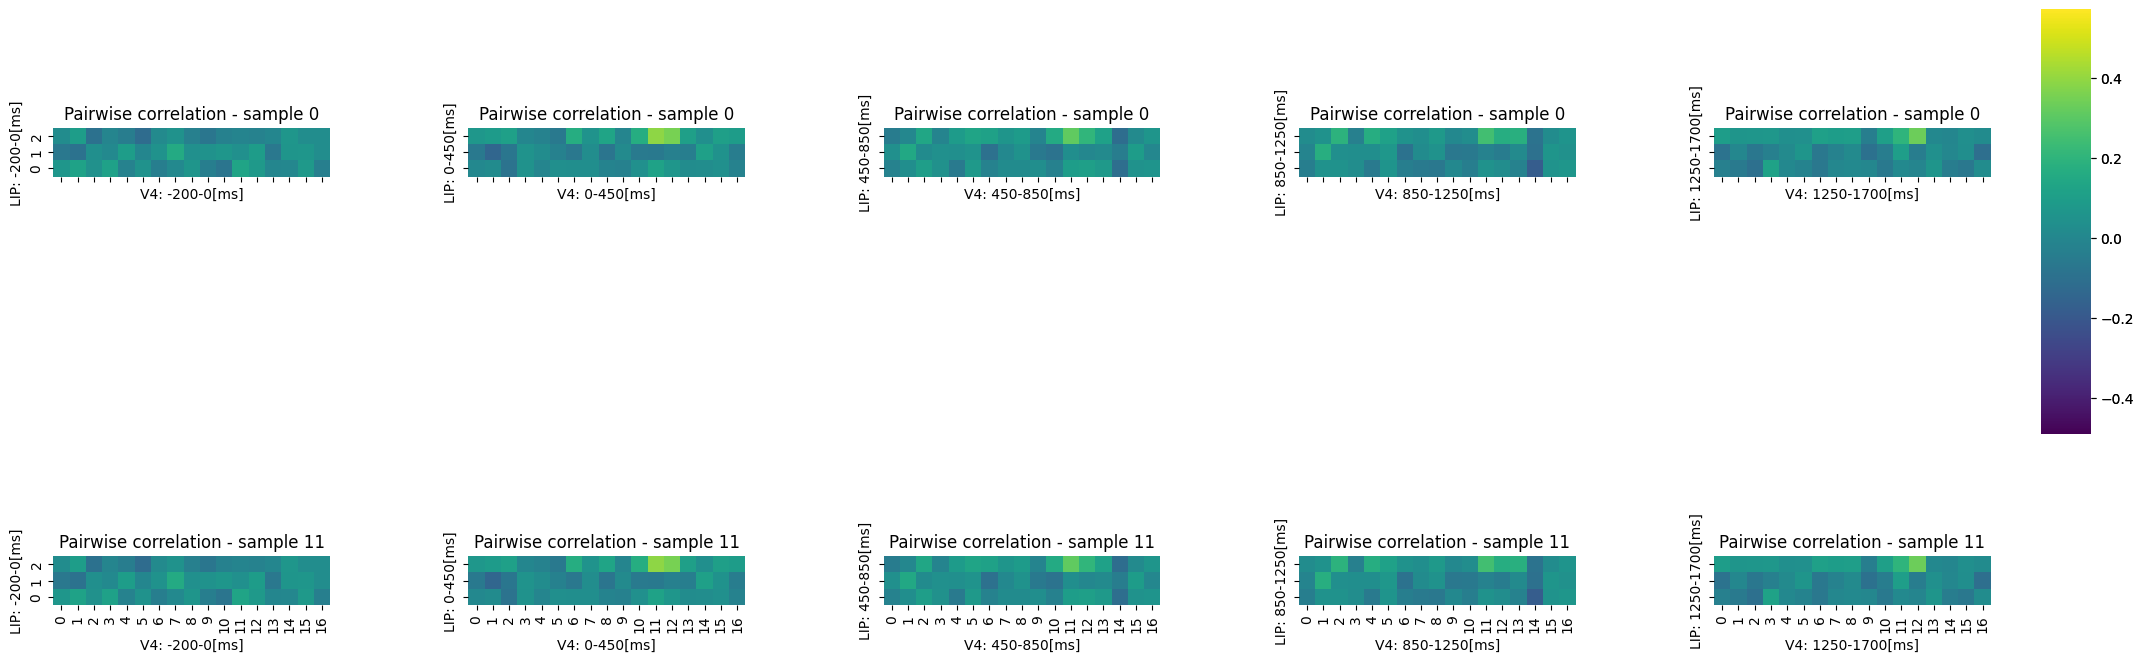

In [15]:
ncols = 5
nrows = len(list(corr_matrix.keys()))#int(np.ceil(((corr_matrix[i_sample].shape[0]-step)/step)/ncols))
if n2>n1: 
    csize=25
    rsize=n1*25/n2
    rsize = rsize if rsize>8.5 else 8.5
else:
    rsize=25
    csize=n2*25/n1
    csize = csize if csize>10 else 10
## Global min and max
global_min = np.inf
global_max = -np.inf
for isamp in corr_matrix.keys():
    for ist,iend in zip([0,200,650,1050,1450],[200,650,1050,1450,1900]):
        mmap = corr_matrix[isamp][:,:,np.arange(trial_dur),np.arange(trial_dur)].copy()
        current_min = np.nanmin(mmap)
        current_max = np.nanmax(mmap)
        if current_min < global_min:
            global_min = current_min
        if current_max > global_max:
            global_max = current_max
            
f,ax = plt.subplots(nrows,ncols,figsize=(csize,rsize),sharex=True,sharey=True)
for ir,i_sample in enumerate(corr_matrix.keys()):
    ic =0
    data = corr_matrix[isamp][:,:,np.arange(trial_dur),np.arange(trial_dur)]
    step=25
    vx = len(neurons1.keys())
    vymax = vx +  len(neurons2.keys())
    # Create a colorbar axis
    cbar_ax = f.add_axes([0.92, 1-0.05-1/nrows, 0.02,1/nrows]) # [left, bottom, width, height]
    #for i in range(0,corr_matrix[i_sample].shape[0]-step,step):
    for ist,iend in zip([0,200,650,1050,1450],[200,650,1050,1450,1900]):
        # I expect to see "RuntimeWarning: Mean of empty slice" in this block
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_corr = np.nanmean(data[:,:,ist:iend],axis=-1)
        mean_corr = np.where(np.isnan(mean_corr),0,mean_corr)
        cbar=True if ic==ncols-1 else False
        _=sns.heatmap(mean_corr,vmax=global_max,vmin=global_min,cmap='viridis', ax=ax[ir,ic],square=True,cbar=cbar,cbar_ax=cbar_ax if cbar else None)
        ax[ir,ic].axes.invert_yaxis()
        ax[ir,ic].set(xlabel='%s: %d-%d[ms]'%(area2.upper(),ist-200,iend-200),ylabel='%s: %d-%d[ms]'%(area1.upper(),ist-200,iend-200))
        ax[ir,ic].set(title='Pairwise correlation - sample %d'%i_sample)
        ic=ic+1
    plt.subplots_adjust(top=0.95, hspace=0.5, wspace=0.5) 

In [16]:
plt.close('all')

In [17]:
f.get_alpha()

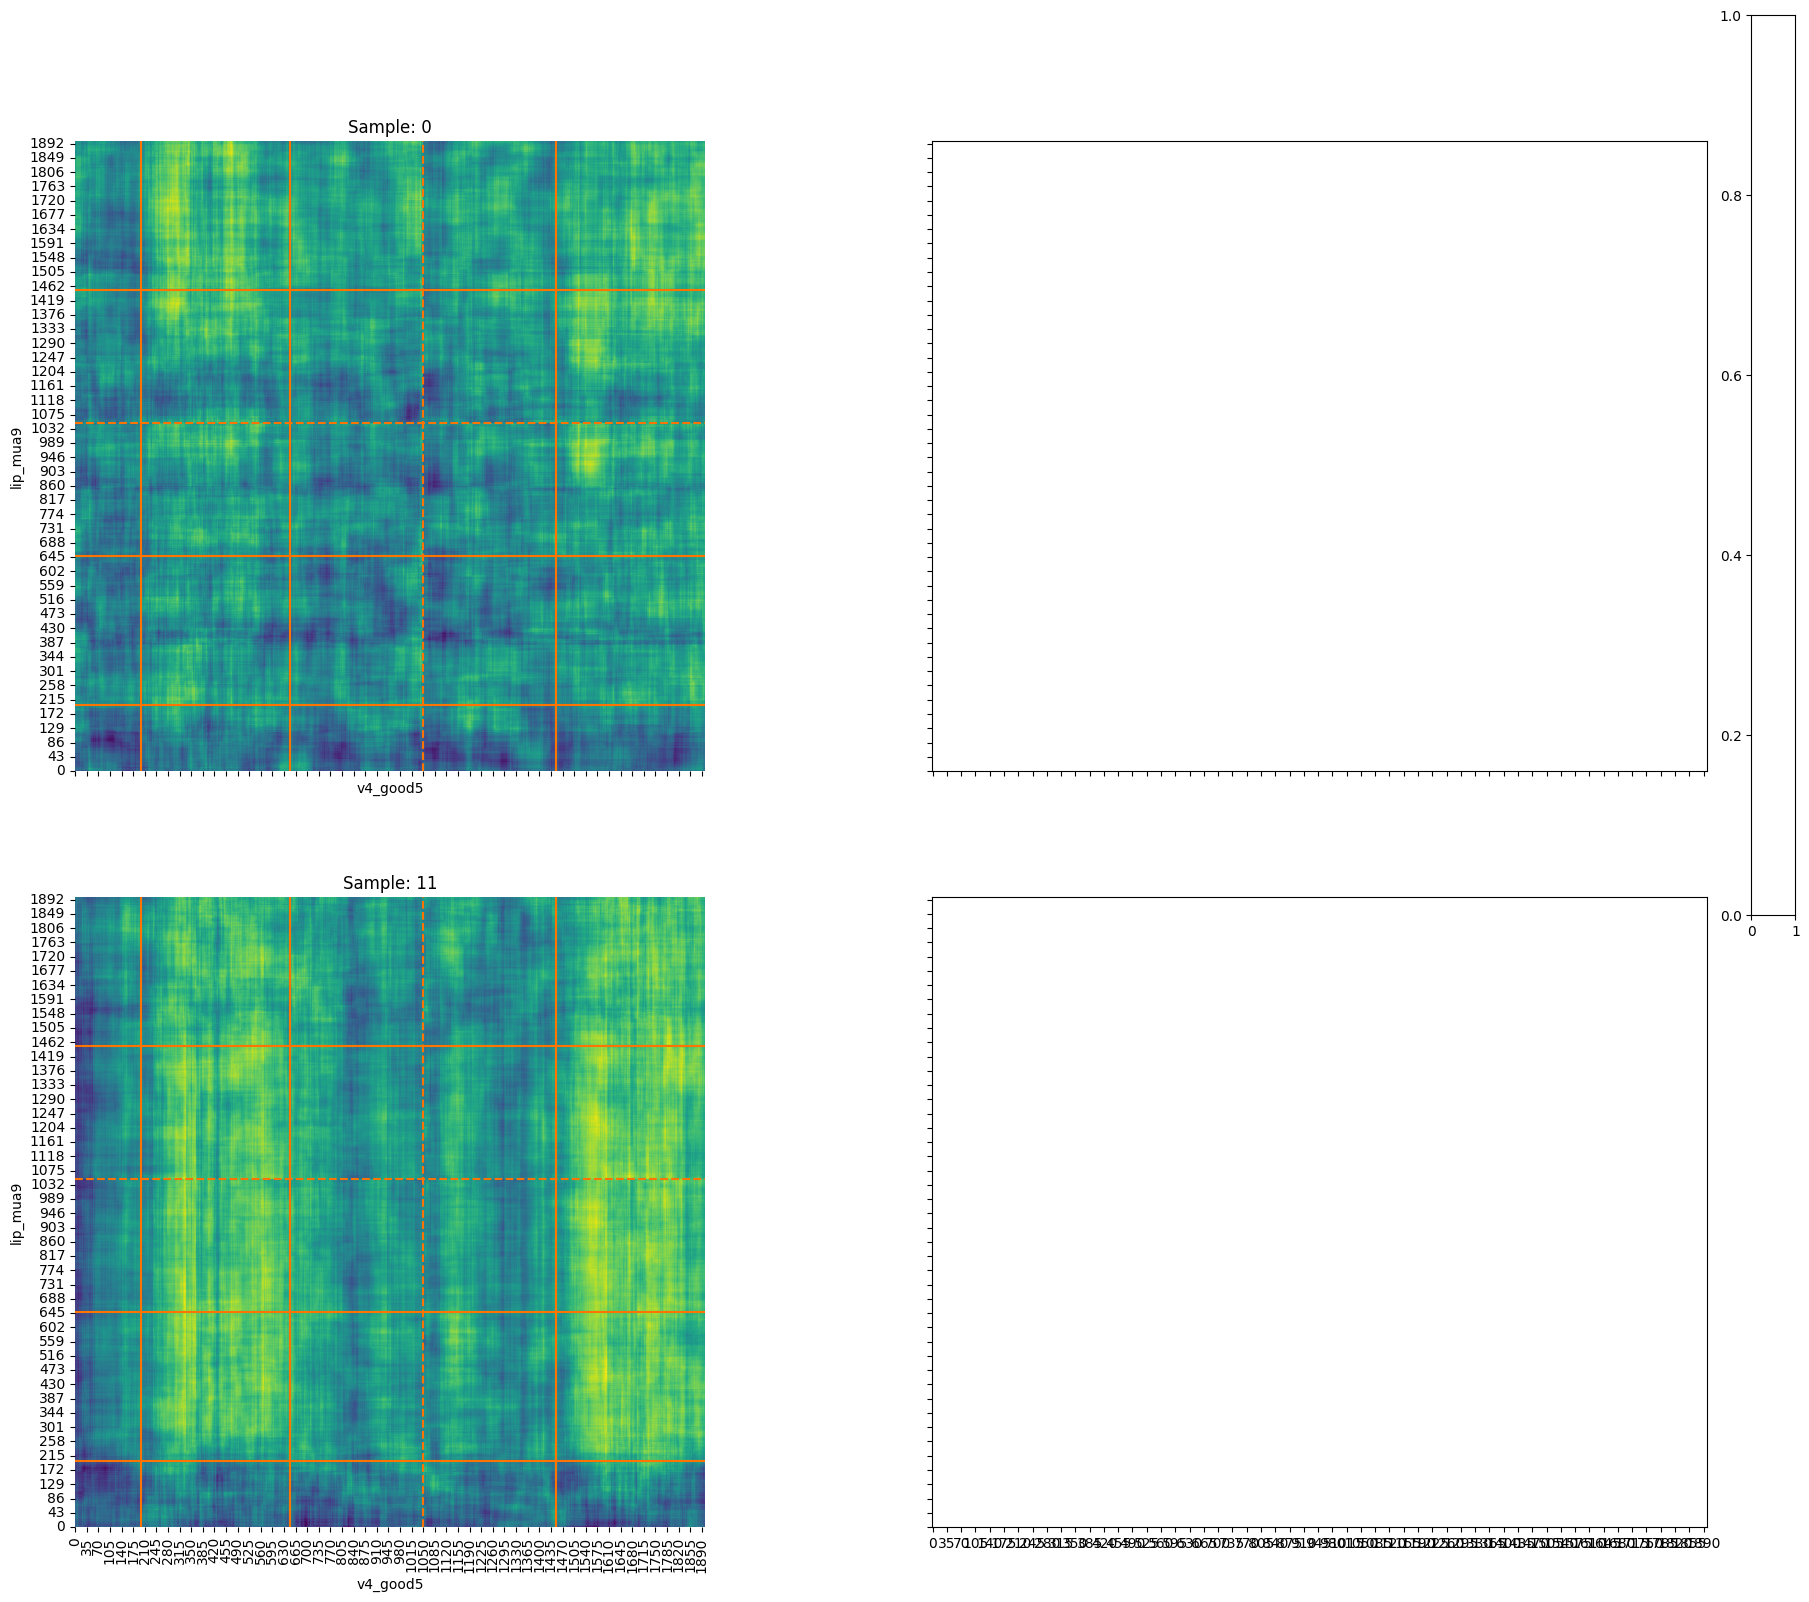

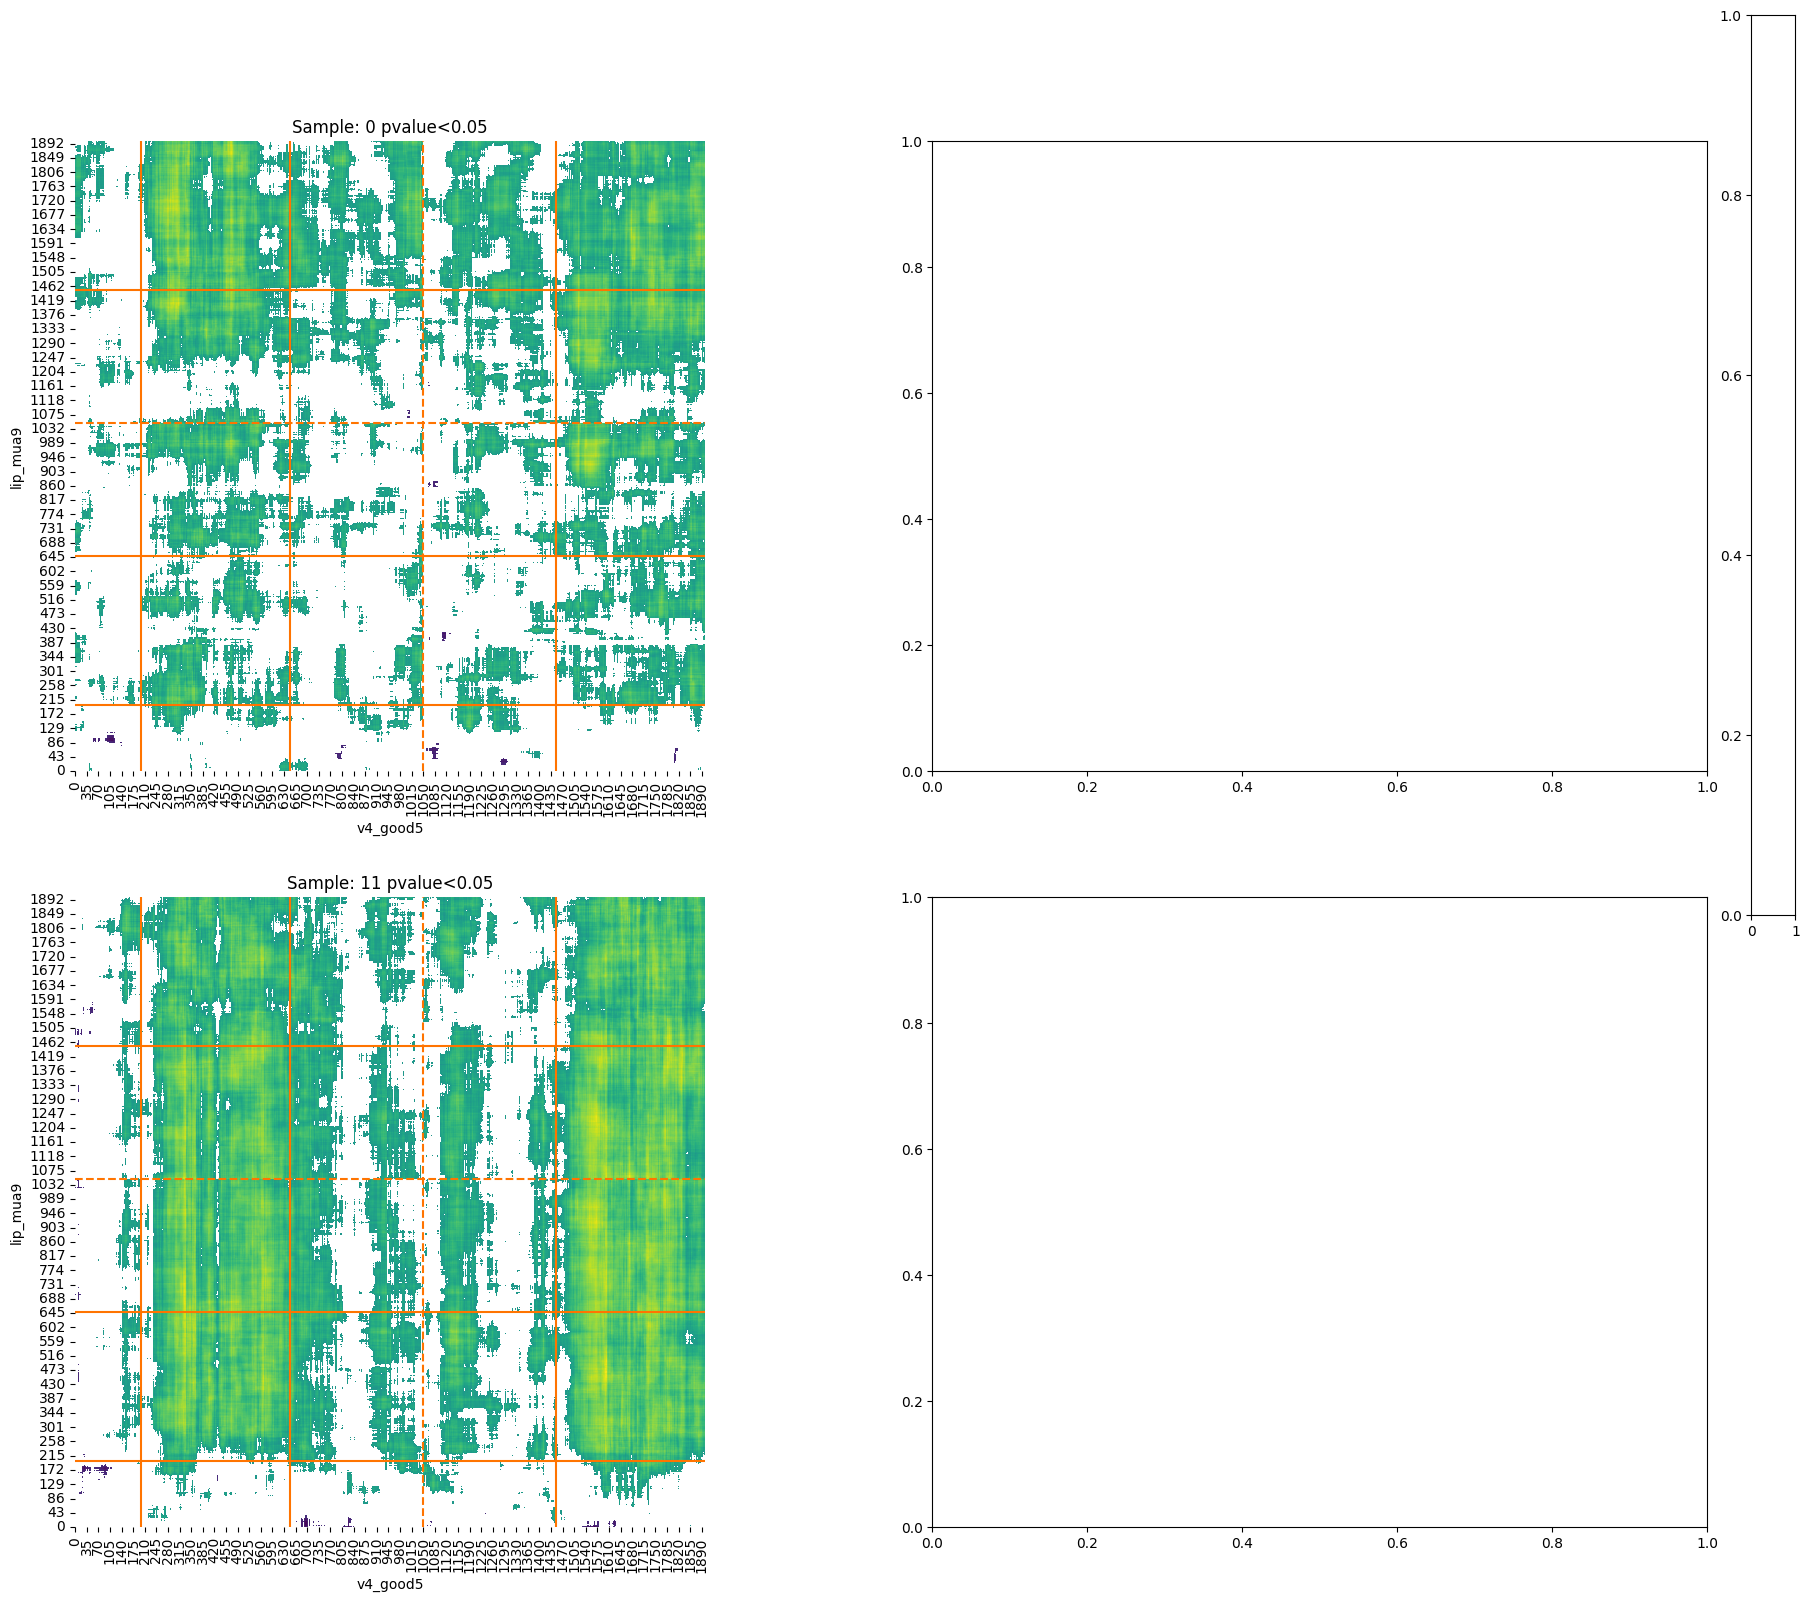

In [18]:
ineu1=2
ineu2=12
global_min = np.inf
global_max = -np.inf
for isamp in corr_matrix.keys():
    mmap = corr_matrix[isamp][ineu1, ineu2].copy()
    current_min = np.nanmin(mmap)
    current_max = np.nanmax(mmap)
    if current_min < global_min:
        global_min = current_min
    if current_max > global_max:
        global_max = current_max
ncols=2
nrows=2
f,ax=plt.subplots(nrows,ncols,figsize=(22,18),sharex=True,sharey=True)
fp,axp=plt.subplots(nrows,ncols,figsize=(22,18))
cbar_ax = f.add_axes([0.92, 1-0.05-1/nrows, 0.02,1/nrows])
cbar_axp = fp.add_axes([0.92, 1-0.05-1/nrows, 0.02,1/nrows]) # [left, bottom, width, height]
ir,ic=0,0
for isamp in corr_matrix.keys():
    if ir==nrows:
        ir=0
        ic=ic+1
    mmap = corr_matrix[isamp][ineu1,ineu2].copy()
    masked_map = p_matrix[isamp][ineu1,ineu2]>0.05
    #mmap[masked_map]=0
    
    
    cbar=True if ic==ncols-1 else False
    _=sns.heatmap(mmap,cmap='viridis',vmin=global_min,vmax=global_max,square=True,ax=ax[ir,ic],cbar=cbar,cbar_ax=cbar_ax if cbar else None)
    _=sns.heatmap(mmap,cmap='viridis',vmin=global_min,vmax=global_max,square=True,ax=axp[ir,ic],mask=masked_map,cbar=cbar,cbar_ax=cbar_axp if cbar else None)
    #_=sns.heatmap(masked_map,cmap='Greys',vmin=-1,vmax=0,square=True,cbar=False,mask=masked_map,ax=ax[ir,ic])

    ax[ir,ic].axes.invert_yaxis()
    ax[ir,ic].vlines([200,650,650+400,650+400+400],0,2100,'#FF7400',['-','-','--','-'])
    ax[ir,ic].hlines([200,650,650+400,650+400+400],0,2100,'#FF7400',['-','-','--','-'])
    ax[ir,ic].set(xlabel=list(neurons2.keys())[ineu2],ylabel=list(neurons1.keys())[ineu1],title='Sample: %d'%isamp)
    # with mask
    axp[ir,ic].axes.invert_yaxis()
    axp[ir,ic].vlines([200,650,650+400,650+400+400],0,2100,'#FF7400',['-','-','--','-'])
    axp[ir,ic].hlines([200,650,650+400,650+400+400],0,2100,'#FF7400',['-','-','--','-'])
    axp[ir,ic].set(xlabel=list(neurons2.keys())[ineu2],ylabel=list(neurons1.keys())[ineu1],title='Sample: %d pvalue<0.05'%isamp)
    ir=ir+1

In [19]:
plt.close('all')

In [20]:
trial_dur

1900

In [21]:
ncols=3
f,ax=plt.subplots(2,ncols,figsize=(22,18))
fp,axp=plt.subplots(2,ncols,figsize=(22,18))
ineu1=1
ineu2=12
ir,ic=0,0
for isamp in corr_matrix.keys():
    if ir==2:
        ir=0
        ic=ic+1
    for t1 in zip([0,200,650,1050,1450],[200,650,1050,1450,1900]):
        for t2 in zip([0,200,650,1050,1450],[200,650,1050,1450,1900]):
    mmap = corr_matrix[isamp][ineu1,ineu2].copy()
    
    

    ir=ir+1

IndentationError: expected an indented block (3728450880.py, line 13)

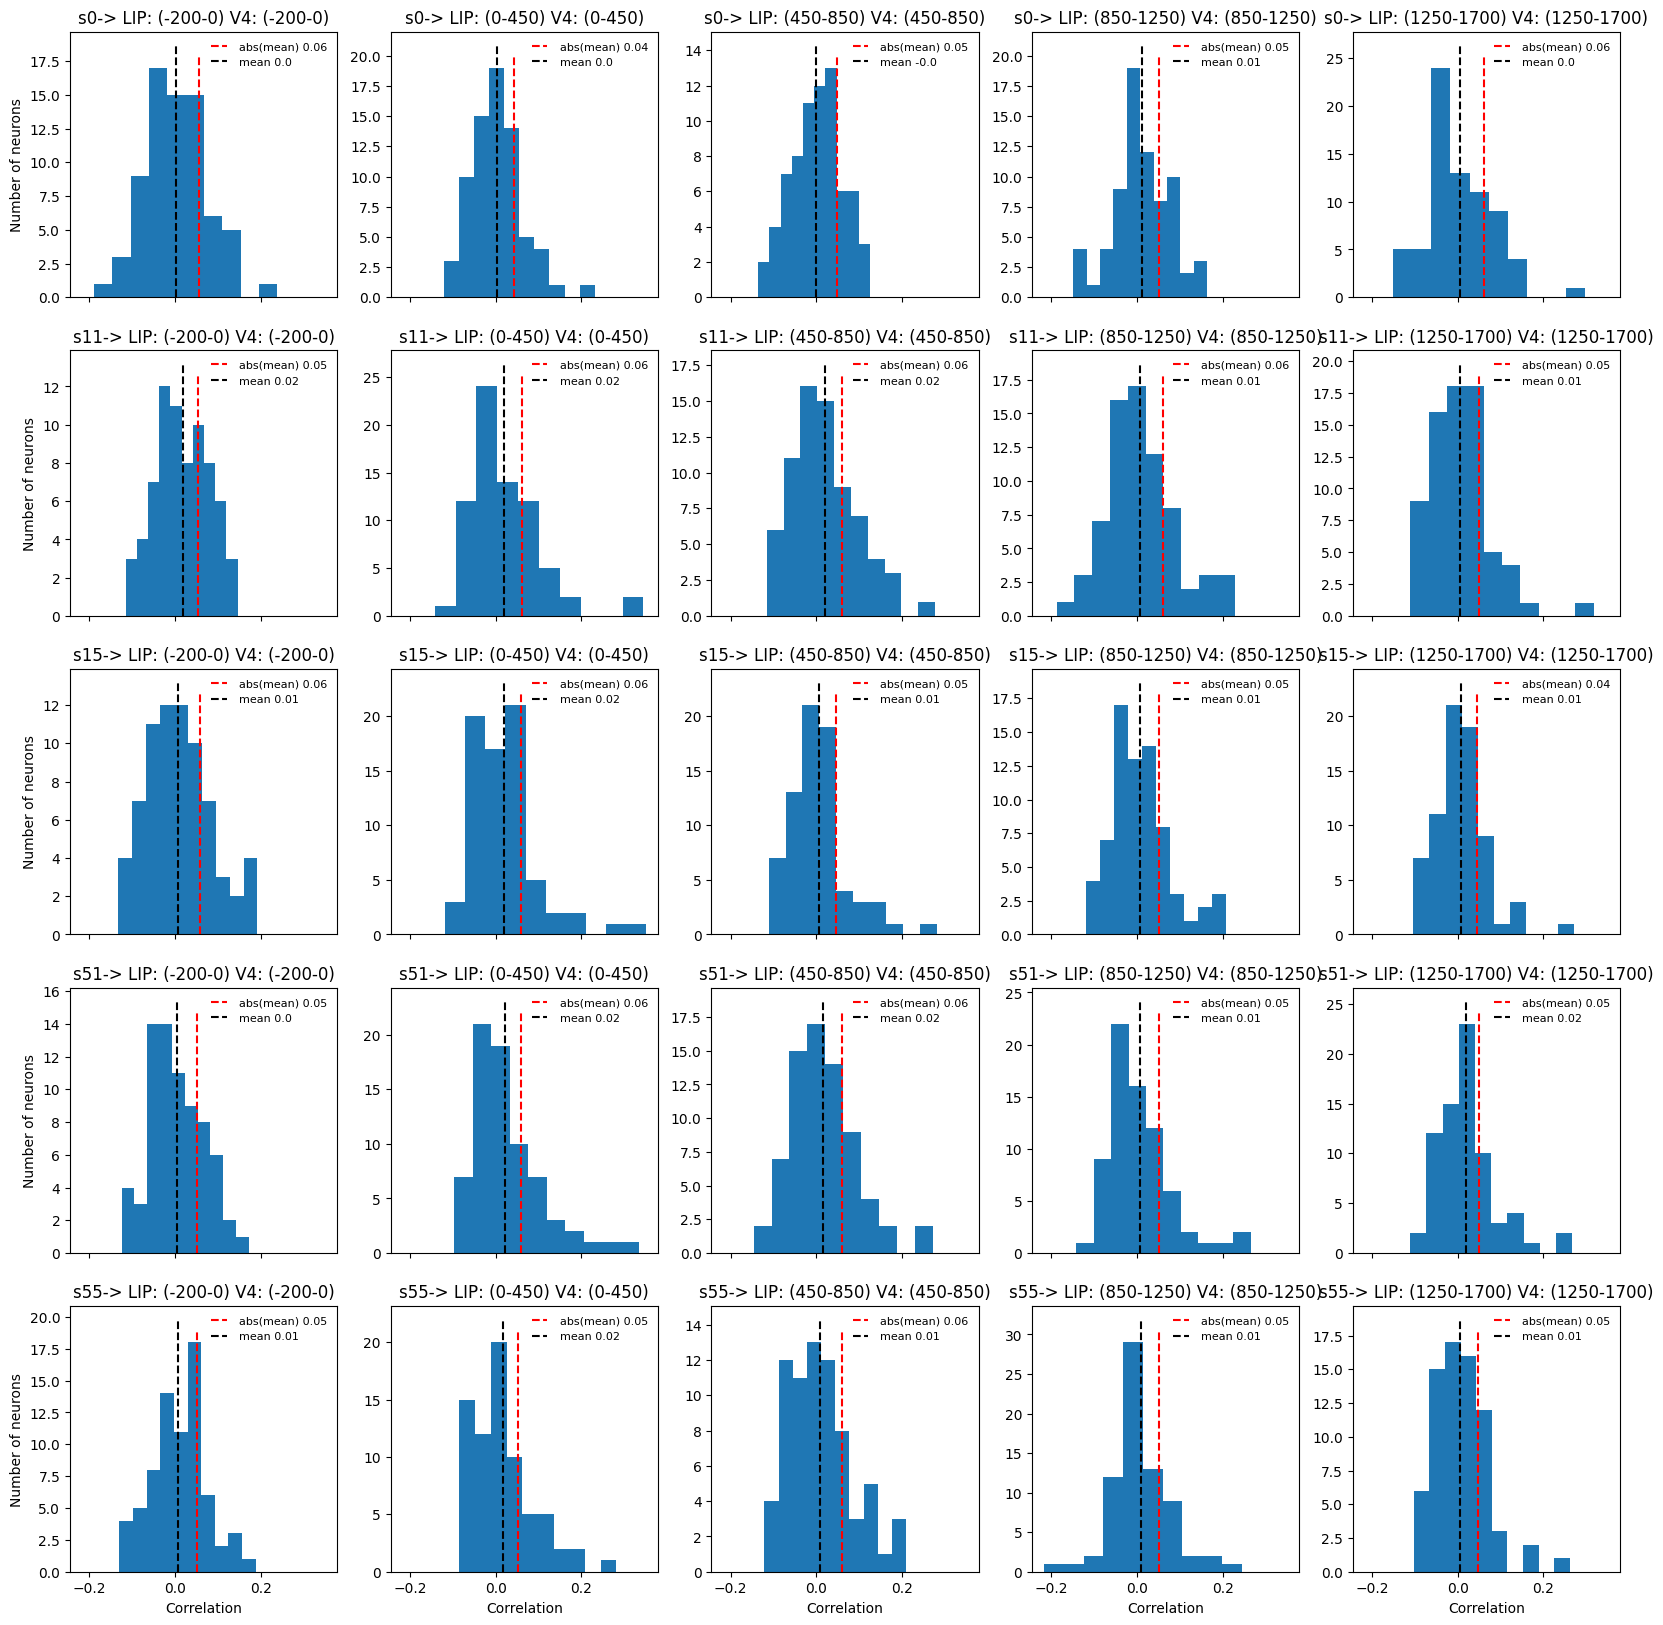

In [ ]:
ncols = 5
nrows = 5#int(np.ceil((corr_matrix[i_sample].shape[0]-step)/step)/ncols)
f,ax = plt.subplots(nrows,ncols,figsize=(ncols*4,nrows*4),sharex=True,sharey=False)
for ir,isamp in enumerate(corr_matrix.keys()):
    data = corr_matrix[isamp][:,:,np.arange(trial_dur),np.arange(trial_dur)]
    ic =0
    vx = len(neurons1.keys())
    vy=len(neurons2.keys())
    vymax = vx +  vy
    all_mean_corr=[]
    for ist,iend in zip([0,200,650,1050,1450],[200,650,1050,1450,1900]):
        # I expect to see "RuntimeWarning: Mean of empty slice" in this block
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_corr =np.nanmean(data[:,:,ist:iend],axis=-1)
        all_mean_corr.append(mean_corr)
        # Area1 - Area2
        a1a2_corr = mean_corr.reshape(-1)
        _ = ax[ir,ic].hist(a1a2_corr,bins=10)
        ax[ir,ic].set(title='s%d-> %s: (%d-%d) %s: (%d-%d)'%(isamp,area1.upper(),ist-200,iend-200,area2.upper(),ist-200,iend-200))
        total_mean_abs=np.nanmean(np.abs(a1a2_corr))
        total_mean=np.nanmean(a1a2_corr)
        _ = ax[ir,ic].vlines(total_mean_abs,0,ax[ir,ic].get_ylim()[1],'r','--',label='abs(mean) %s'%str(np.round(total_mean_abs,2)))
        _ = ax[ir,ic].vlines(total_mean,0,ax[ir,ic].get_ylim()[1],'k','--',label='mean %s'%str(np.round(total_mean,2)))
        _ = ax[ir,ic].legend(fontsize=8,scatterpoints=5,columnspacing=1,framealpha=0,loc='upper right')
        if ir == nrows-1:
            ax[ir,ic].set(xlabel='Correlation')
        if ic == 0:
            ax[ir,ic].set(ylabel='Number of neurons')
        ic=ic+1
    #plt.subplots_adjust(top=0.95, hspace=0.15, wspace=0.15) 

In [ ]:
plt.close('all')

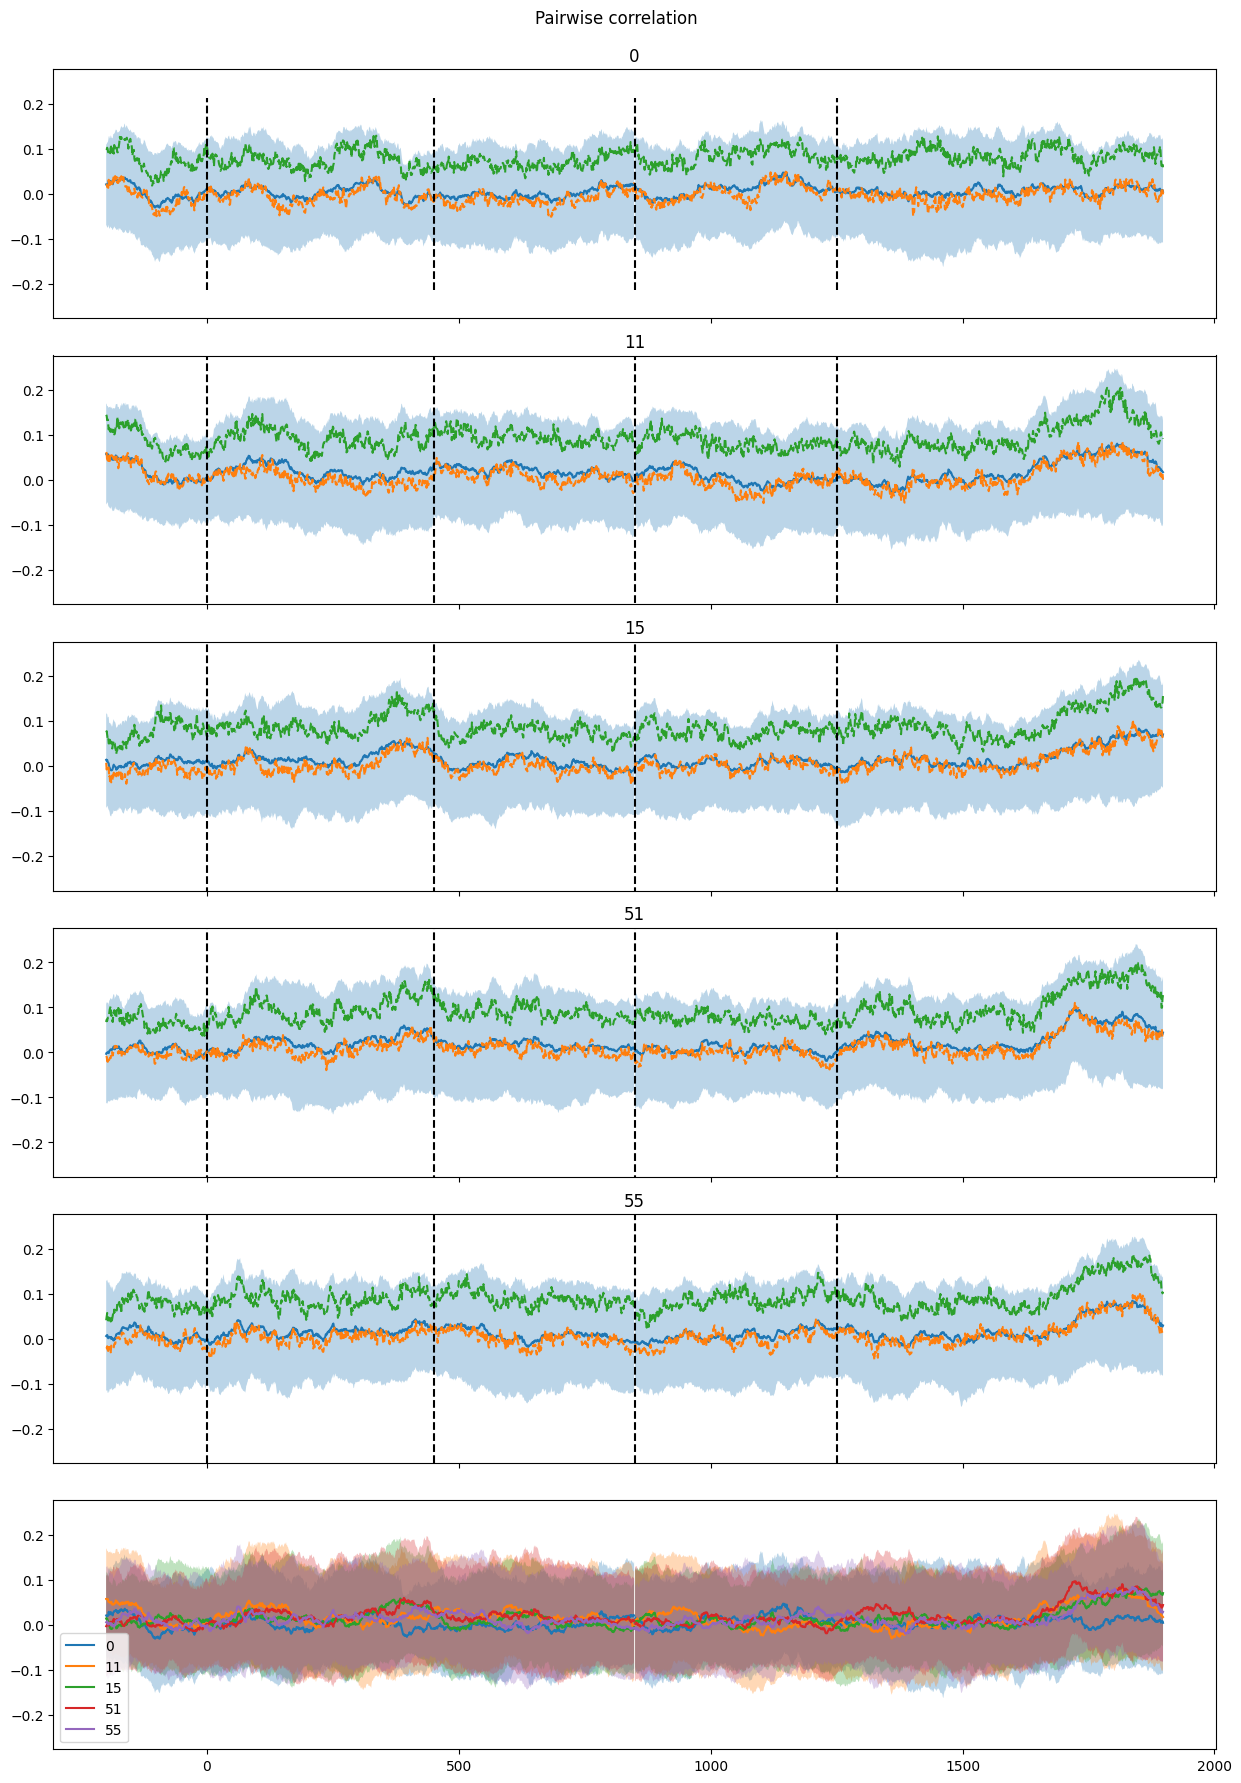

In [ ]:
f,ax = plt.subplots(6,figsize=(15,20),sharex=True,sharey=True)
for i_plot, isamp in enumerate(corr_matrix.keys()):
    data = corr_matrix[isamp][:,:,np.arange(trial_dur),np.arange(trial_dur)]
    all_mean_corr,all_std_corr,all_p75_corr,all_p50_corr=[],[],[],[]
    for i in range(0,data.shape[-1]):
        # I expect to see "RuntimeWarning: Mean of empty slice" in this block
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_corr = np.nanmean(data[:,:,i])
            p50_corr = np.nanpercentile(data[:,:,i],50)
            p75_corr = np.nanpercentile(data[:,:,i],75)
            std_corr = np.nanstd(data[:,:,i])
        all_mean_corr.append(mean_corr)
        all_std_corr.append(std_corr)
        all_p75_corr.append(p75_corr)
        all_p50_corr.append(p50_corr)

    ax[i_plot].plot(np.arange(len(all_mean_corr))-200,all_mean_corr)
    ax[i_plot].plot(np.arange(len(all_mean_corr))-200,all_p50_corr,'--')
    ax[i_plot].plot(np.arange(len(all_mean_corr))-200,all_p75_corr,'--')
    ax[i_plot].fill_between(np.arange(len(all_mean_corr))-200,np.array(all_std_corr)+np.array(all_mean_corr),-np.array(all_std_corr)+np.array(all_mean_corr),  alpha=.3, linewidth=0)
    ylim = np.nanmax(np.abs(np.array(all_std_corr)+np.array(all_mean_corr)))+0.05
    ax[i_plot].set_ylim(-ylim,ylim)
    ax[i_plot].vlines([0,450,850,1250],-ylim,ylim,'k','--')
    ax[i_plot].set(title=str(isamp))
    ax[5].plot(np.arange(len(all_mean_corr))-200,all_mean_corr,label=str(isamp))
    ax[5].fill_between(np.arange(len(all_mean_corr))-200,np.array(all_std_corr)+np.array(all_mean_corr),-np.array(all_std_corr)+np.array(all_mean_corr),  alpha=.3, linewidth=0)
f.suptitle('Pairwise correlation')
ax[5].legend()
plt.subplots_adjust(top=0.95, hspace=0.15, wspace=0.15) 

In [ ]:
plt.close('all')